In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from tqdm.notebook import tqdm
import datetime

from models.mad_gan import Generator, Discriminator
from tools.viz import plot_anomalies, plot_single_var, plot_to_tensorboard, plot_anomaly_scores, plot_train_hist
from tools.anomaly import madgan_reconstruction, madgan_reconstruction_discr_loss, feature_anomaly_score
from tools.logging import Logger

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 32
        self.nworkers = 4
        self.shuffle = True
        self.drop_last = False
        self.method = "window_mag"
        self.scaler = MinMaxScaler((-1,1))
        self.wsize = 20
        self.ncomps = 100
        self.profiles = ["CR1992"]
        
        # Train params
        self.G_lr = 0.0001
        self.D_lr = 0.0002
        self.epochs = 25
        self.G_niters = 5
        self.D_niters = 10
        
        self.model_out = Path('./runs/madgan/' + time_id)
        self.train_plots = True

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        (self.model_out / "img").mkdir(exist_ok=True)
        
        # logging
        self.tags = ["madgan", "test"]
        self.desc = "PCA diff lr"
        self.type = "CR1992"
        
opts = Options()


# Setup Training Dataset

In [2]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=True,
    is_train=True,
    scaler=opts.scaler,
    window_size=opts.wsize,
    use_pca=True,
    pca_scaler=MinMaxScaler((-1,1)),
    n_components=opts.ncomps   
)
dataset.filter_profiles(opts.profiles)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Removed 705 extreme values
Window size: 20
Window shape:  torch.Size([20, 100])
First window:
 tensor([[ 0.3218, -0.4266,  0.2210,  ..., -0.1032, -0.0899, -0.1021],
        [ 0.3495, -0.4306,  0.1209,  ..., -0.1085, -0.0761, -0.1022],
        [ 0.3581, -0.4174,  0.1211,  ..., -0.1091, -0.0622, -0.1036],
        ...,
        [ 0.2959, -0.4294,  0.3080,  ..., -0.1172, -0.0760, -0.0997],
        [ 0.3041, -0.3909,  0.3520,  ..., -0.1142, -0.0654, -0.1034],
        [ 0.3016, -0.3971,  0.3481,  ..., -0.1054, -0.0777, -0.0984]])
Inputs shape: (11066, 100)
Inputs head:
 [[ 3.21756463e-01 -4.26625339e-01  2.20992889e-01 -2.50984976e-02
  -4.20985712e-02 -6.64511573e-01 -1.60029692e-01 -5.05343101e-01
  -2.43408116e-01 -1.52363575e-01 -3.92539438e-01 -2.14906805e-01
  -8.56068285e-02 -5.34105483e-02 -7.61943628e-02 -2.35262294e-01
  -1.87125593e-01 -3.25461310e-02 -2.35553495e-01 -7.03668487e-01
  -3.34483246e-01 -5.71081210e-02 -5.62032368e-02 -1.76204000e-01
  -1.41491803e-01 -4.97727023e-02 

In [3]:
# dataset.plot(title="Magnetic Field")

# Models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

netG = Generator(
    input_size=dataset.inputs.shape[1],
    hidden_size=200,
    output_size=dataset.inputs.shape[1],
    nlayers=3,
    dropout=0,
    bidirectional=False,
    arch='GRU',
).to(device)

netD = Discriminator(
    input_size=dataset.inputs.shape[1],
    hidden_size=200,
    nlayers=1,
    dropout=0,
    bidirectional=False,
    arch='GRU',
).to(device)

Using device:  cuda:0


In [5]:
netG.train()

Generator(
  (rnn): GRU(100, 200, num_layers=3, batch_first=True)
  (linear): Linear(in_features=200, out_features=100, bias=True)
)

In [6]:
netD.train()

Discriminator(
  (rnn): GRU(100, 200, batch_first=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [7]:
logger = Logger([netG, netD], opts.model_out / f"{time_id}.md", vars(opts))

# Training

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

nseqs = opts.wsize

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opts.D_lr)
optimizerG = optim.Adam(netG.parameters(), lr=opts.G_lr)

In [9]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for i, (x, _filename) in enumerate(dataloader): # tqdm(enumerate(dataloader), desc=f"Epoch [{epoch}/{opts.epochs}]", total=len(dataloader), leave=False):
        
        # Format batch
        real = x.to(device)
        b_size, seq_len = real.size(0), real.size(1)
        real_labels = torch.full((b_size, nseqs, 1), real_label, dtype=torch.float, device=device)
        
        # Train discriminator network to maximize log(D(x)) + log(1 - D(G(z)))
        for _ in range(opts.D_niters):
            netD.zero_grad()
            
            # Train with real batch
            output = netD(real)
            errD_real = criterion(output, real_labels)
            errD_real.backward()
            
            # Train with fake batch
            fake = netG(torch.randn_like(real, device=device))
            fake_labels = torch.full((b_size, nseqs, 1), fake_label, dtype=torch.float, device=device)
            
            output = netD(fake.detach())
            errD_fake = criterion(output, fake_labels)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizerD.step()
        D_losses.append(errD.item())
        
        # Train generator network to maximize log(D(G(z)))
        for _ in range(opts.G_niters):
            netG.zero_grad()
            
            fake = netG(torch.randn_like(real, device=device))
            output = netD(fake)
            errG = criterion(output, real_labels)
            errG.backward()
            optimizerG.step()
        G_losses.append(errG.item())
        # send losses to tensorboard
        iters += 1
        
    # Calculate epoch losses
    output = netD(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()
    
    fake = netG(torch.randn_like(real, device=device)).detach()
    output = netD(fake)
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    
    errD = errD_real + errD_fake
    errG = criterion(output, real_labels)

    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs,
                errD.item(), errG.item(), D_x, D_G_z1))

    # save best model if total loss is better than last 
    # and distance between losses is better than last (model convergence)
    if abs(errD-errG).item() < best_loss_dist and epoch > 2 and D_x > 0.6: 
        best_loss_dist = torch.abs(errD-errG).item()
        torch.save(netG.state_dict(), opts.model_out / 'Gbest.pth')
        torch.save(netD.state_dict(), opts.model_out / 'Dbest.pth')
        
        if opts.train_plots:
            # fake = dataset.unscale(fake.detach().cpu().numpy())
            fake = dataset.flatten(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f"img/{epoch}_best", dpi=200)
            plt.close(fig)
    elif epoch % 5 == 0:
        torch.save(netG.state_dict(), opts.model_out / f'G{epoch}.pth')
        torch.save(netD.state_dict(), opts.model_out / f'D{epoch}.pth')
        
        if opts.train_plots:
            fake = dataset.flatten(fake.detach().cpu().numpy())
            # fake = dataset.unscale(fake.detach().cpu().numpy())
            fig = plot_single_var(fake, 
                            title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f} - Loss diff: {best_loss_dist:.4f}",
                            dpi=200, scale="linear")
            fig.savefig(opts.model_out / f'img/inter_{epoch}.png', dpi=200)
            plt.close(fig)
            
        train_f = plot_train_hist(D_losses, G_losses, opts.model_out)
        plt.close(train_f)
    

Starting Training Loop...


Epoch [0/25]:   0%|          | 0/70 [00:00<?, ?it/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ivsaav/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ivsaav/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 61, in fetch
    return self.collate_fn(data)
  File "/home/ivsaav/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/ivsaav/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 143, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/ivsaav/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 143, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/ivsaav/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 120, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/ivsaav/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 162, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


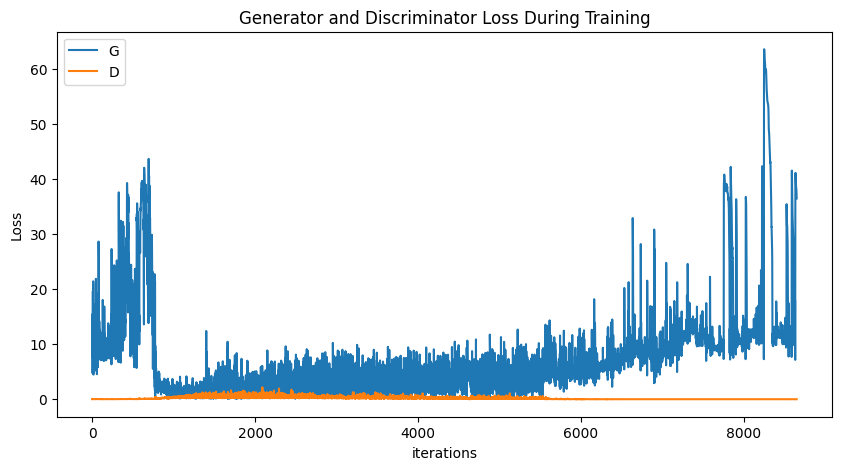

In [ ]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Plot Random Generated Inputs

In [ ]:
# # load best model
# netG.load_state_dict(torch.load(opts.model_out / 'G.pth'))

In [ ]:
# lines = []

# # generate random samples
# for i in range(100):
#     noise = torch.randn_like(real, device=device)
#     fake, _ = netG(noise)
#     fake = fake.flatten(end_dim=1).detach().cpu().numpy()
#     lines.append(fake)


# inv_fake_data = dataset.unscale(np.array(lines))
# # inv_fake_data = pd.DataFrame(inv_fake_data)

In [ ]:
# plot_data_values(inv_fake_data, "Random Generated", label="B [G]", scale="log")

# Anomaly Detection

In [ ]:

netD.train(True)
netG.train(True)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    # models_dir = Path("runs/madgan/0322-1636")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netG.load_state_dict(torch.load(opts_eval.models_dir / 'Gbest.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'Dbest.pth'))

<All keys matched successfully>

In [ ]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataset.filter_profiles(opts.profiles)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Window size: 20
Window shape:  torch.Size([20, 100])
First window:
 tensor([[ 0.3218, -0.4266,  0.2210,  ..., -0.1032, -0.0899, -0.1021],
        [ 0.3495, -0.4306,  0.1209,  ..., -0.1085, -0.0761, -0.1022],
        [ 0.3581, -0.4174,  0.1211,  ..., -0.1091, -0.0622, -0.1036],
        ...,
        [ 0.2959, -0.4294,  0.3080,  ..., -0.1172, -0.0760, -0.0997],
        [ 0.3041, -0.3909,  0.3520,  ..., -0.1142, -0.0654, -0.1034],
        [ 0.3016, -0.3971,  0.3481,  ..., -0.1054, -0.0777, -0.0984]])
Inputs shape: (11771, 100)
Inputs head:
 [[ 3.21756463e-01 -4.26625339e-01  2.20992889e-01 -2.50984976e-02
  -4.20985712e-02 -6.64511573e-01 -1.60029692e-01 -5.05343101e-01
  -2.43408116e-01 -1.52363575e-01 -3.92539438e-01 -2.14906805e-01
  -8.56068285e-02 -5.34105483e-02 -7.61943628e-02 -2.35262294e-01
  -1.87125593e-01 -3.25461310e-02 -2.35553495e-01 -7.03668487e-01
  -3.34483246e-01 -5.71081210e-02 -5.62032368e-02 -1.76204000e-01
  -1.41491803e-01 -4.97727023e-02 -1.47972887e-01 -2.27049888

## Discriminator Classification

In [ ]:
scores = []
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    outputs = netD(x.to(device))
    # calculate mean classification score for each sample
    for sample, filename in zip(outputs, filenames):
        # print(sample, filename)
        class_avg = sample[0]
        scores.append((filename, 1-class_avg.item()))

Anomaly Threshold:  0.692146897315979
Found 352 anomalies


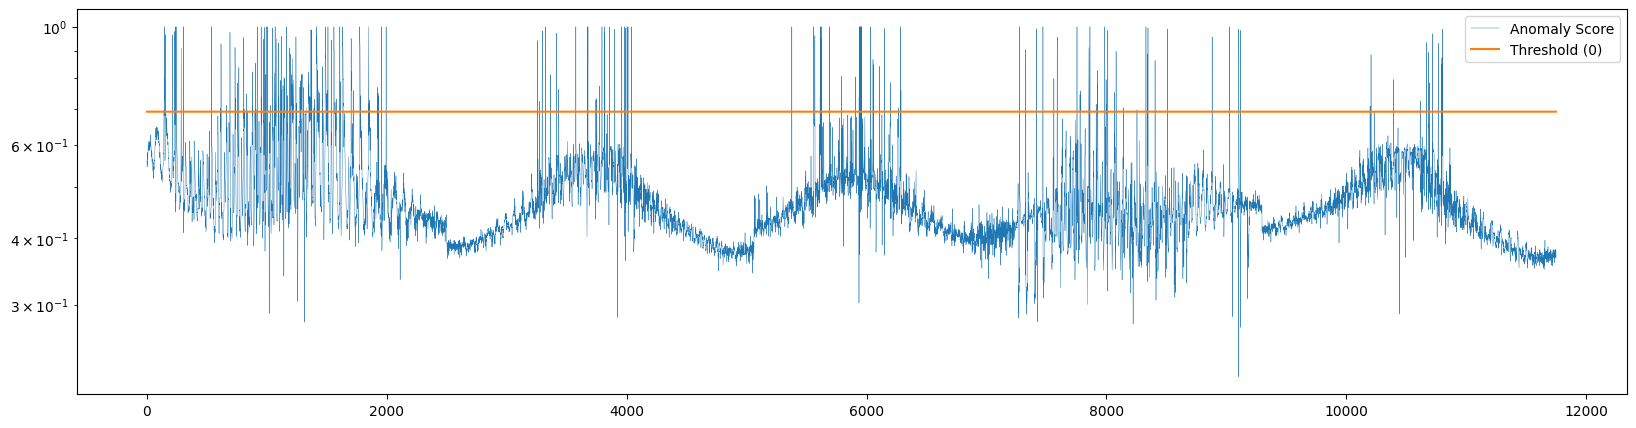

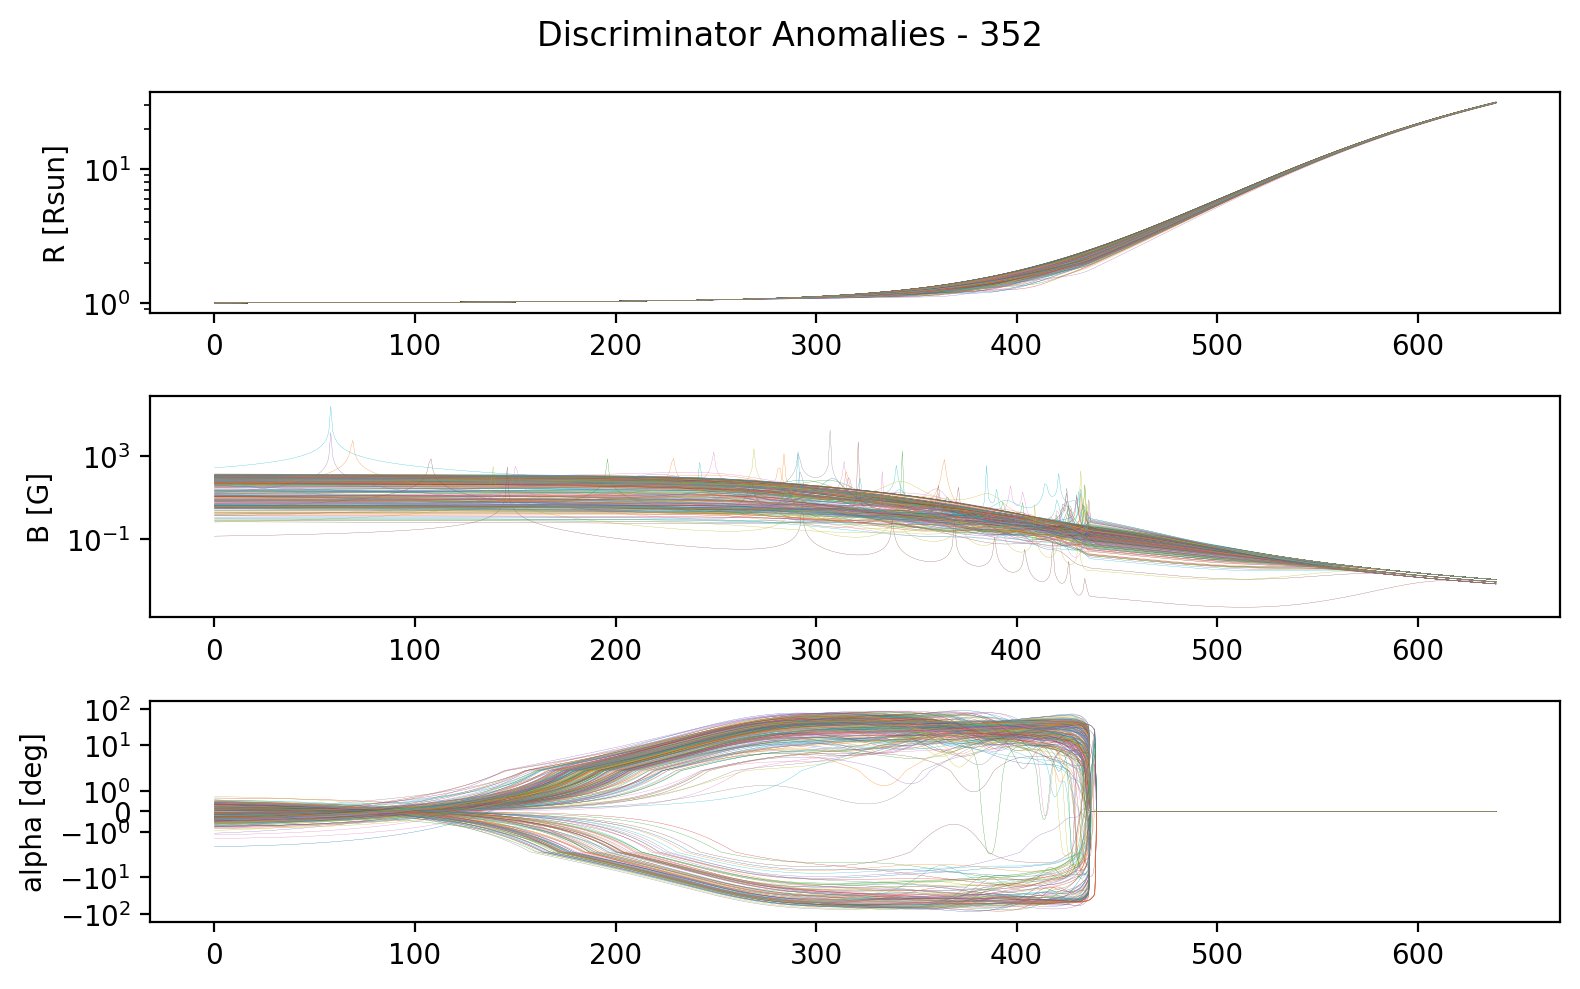

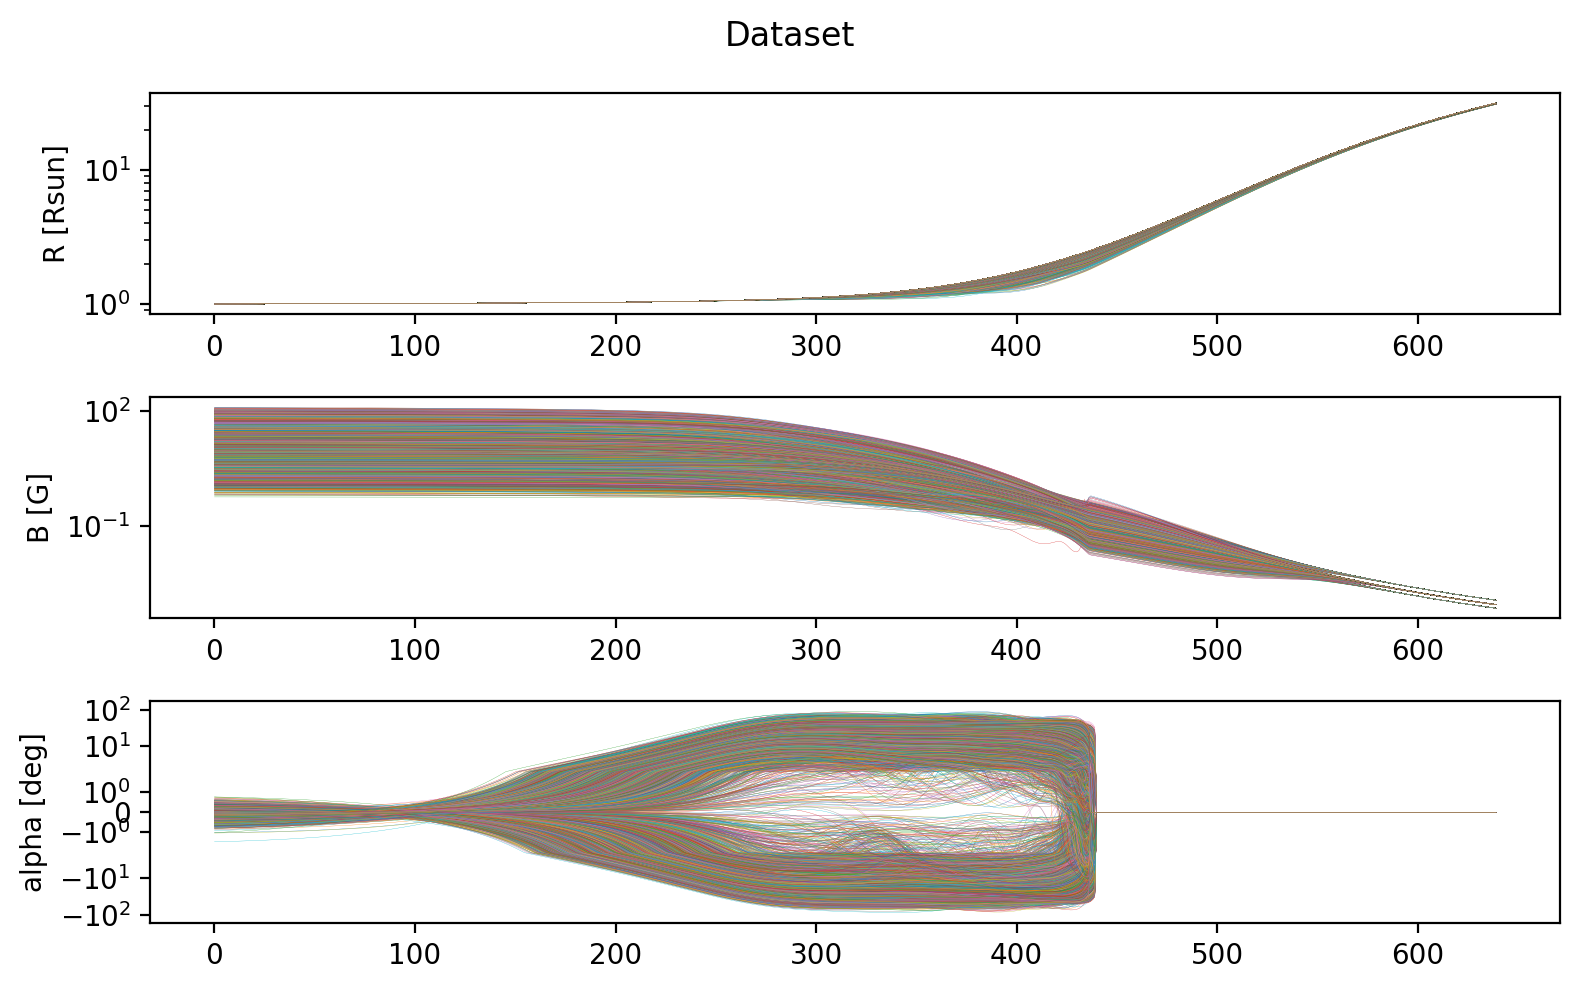

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.03, opts.data_path, opts_eval.models_dir /  f"img/discr",
                        scale="log", method="Discriminator")

## Reconstruction Based

In [ ]:
def reconstruction_anomaly_scores(dataloader, netG : nn.Module, netD : nn.Module, device : str,
                                  max_iters=100, reconstr_fn=madgan_reconstruction):
    mse_scores = []
    for i, (x, filenames) in enumerate(dataloader, 0):
        _z, loss = reconstr_fn(x, netG, netD, device, max_iters)
        mse_scores.extend(zip(filenames, [l.sum(-1).detach().cpu().numpy()[0] for l in loss]))
        print(f"[{i}/{len(dataloader)}]", end='\r', flush=True)
        
    return mse_scores

### MSE Reconstruction

In [ ]:
reconstr_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device, opts_eval.niter, madgan_reconstruction)

Anomaly Threshold:  6.098184
Found 352 anomalies


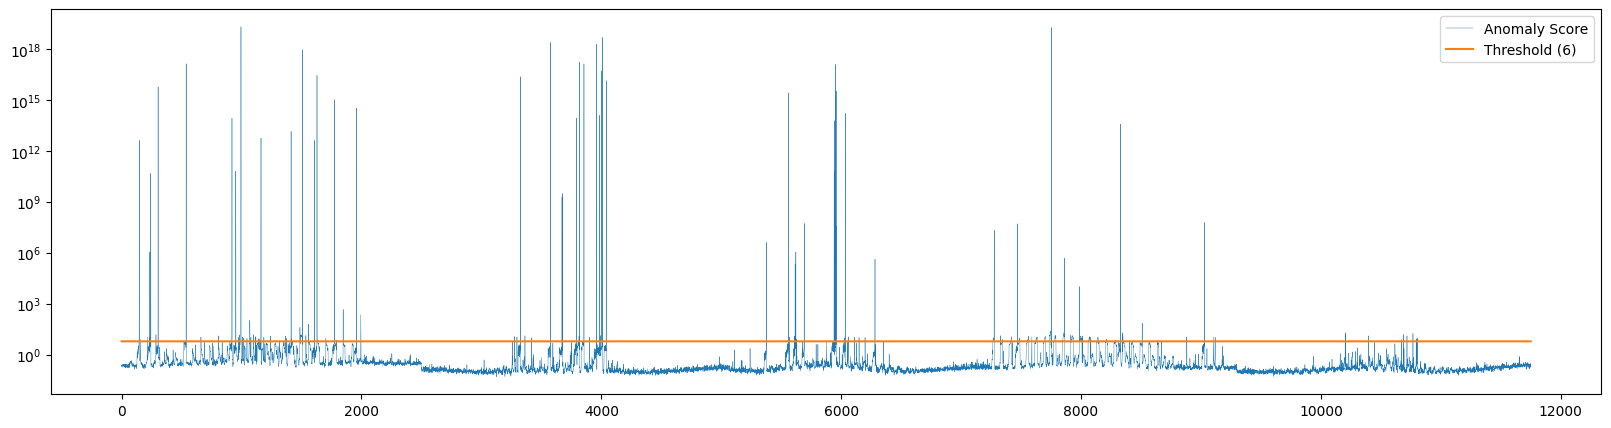

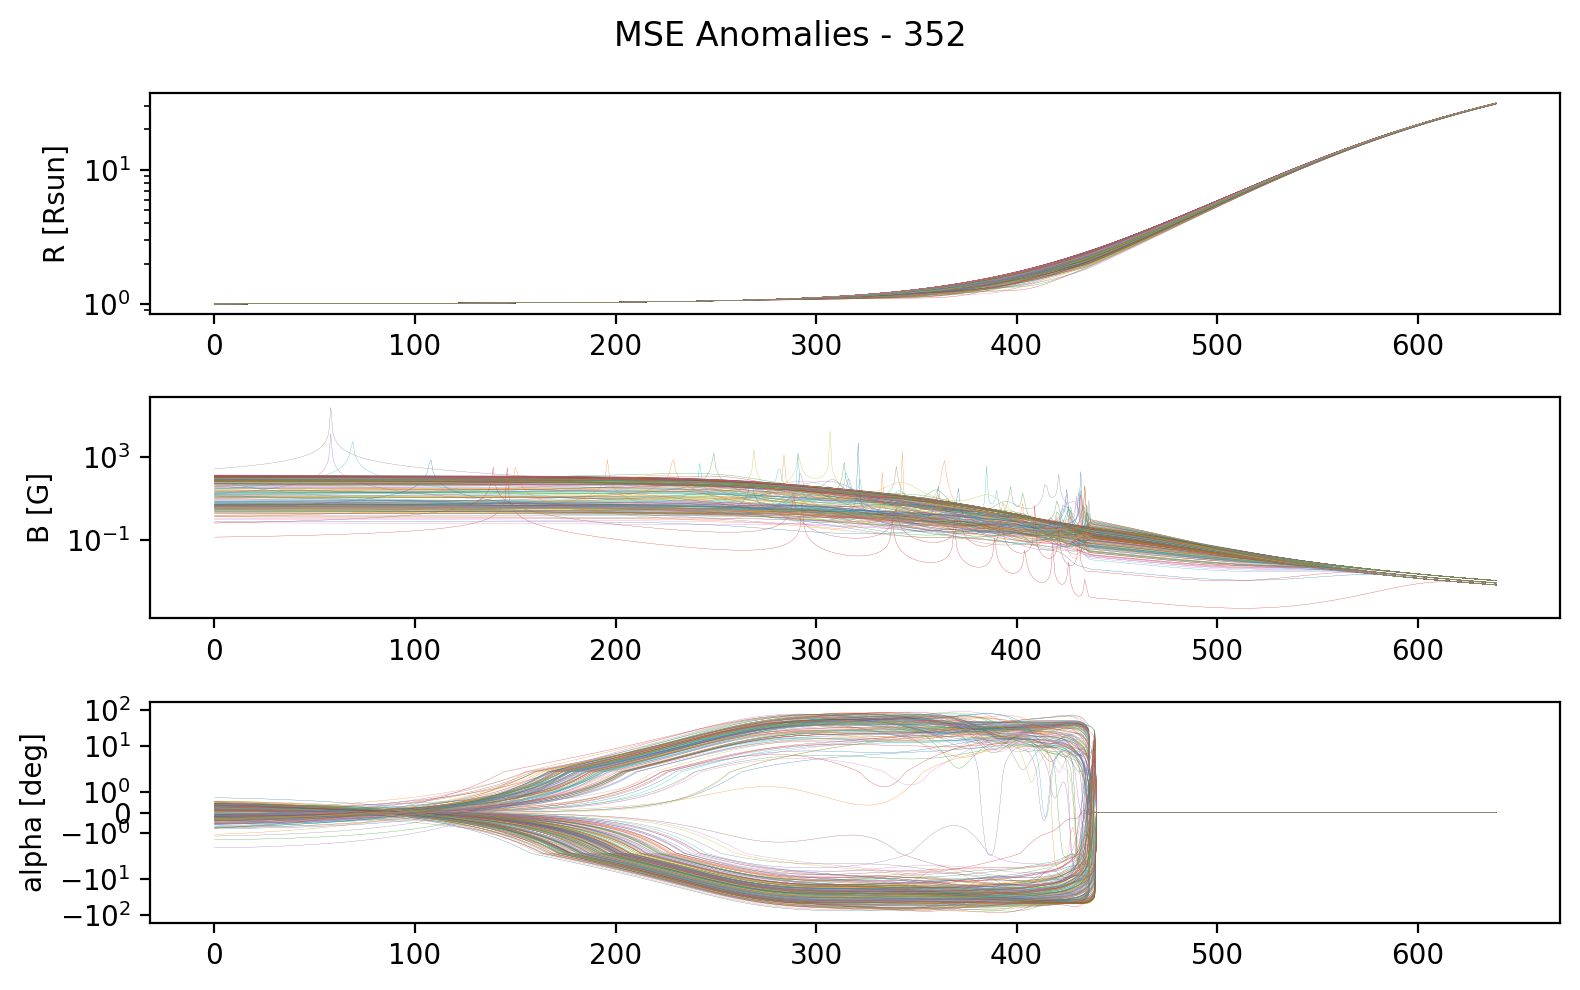

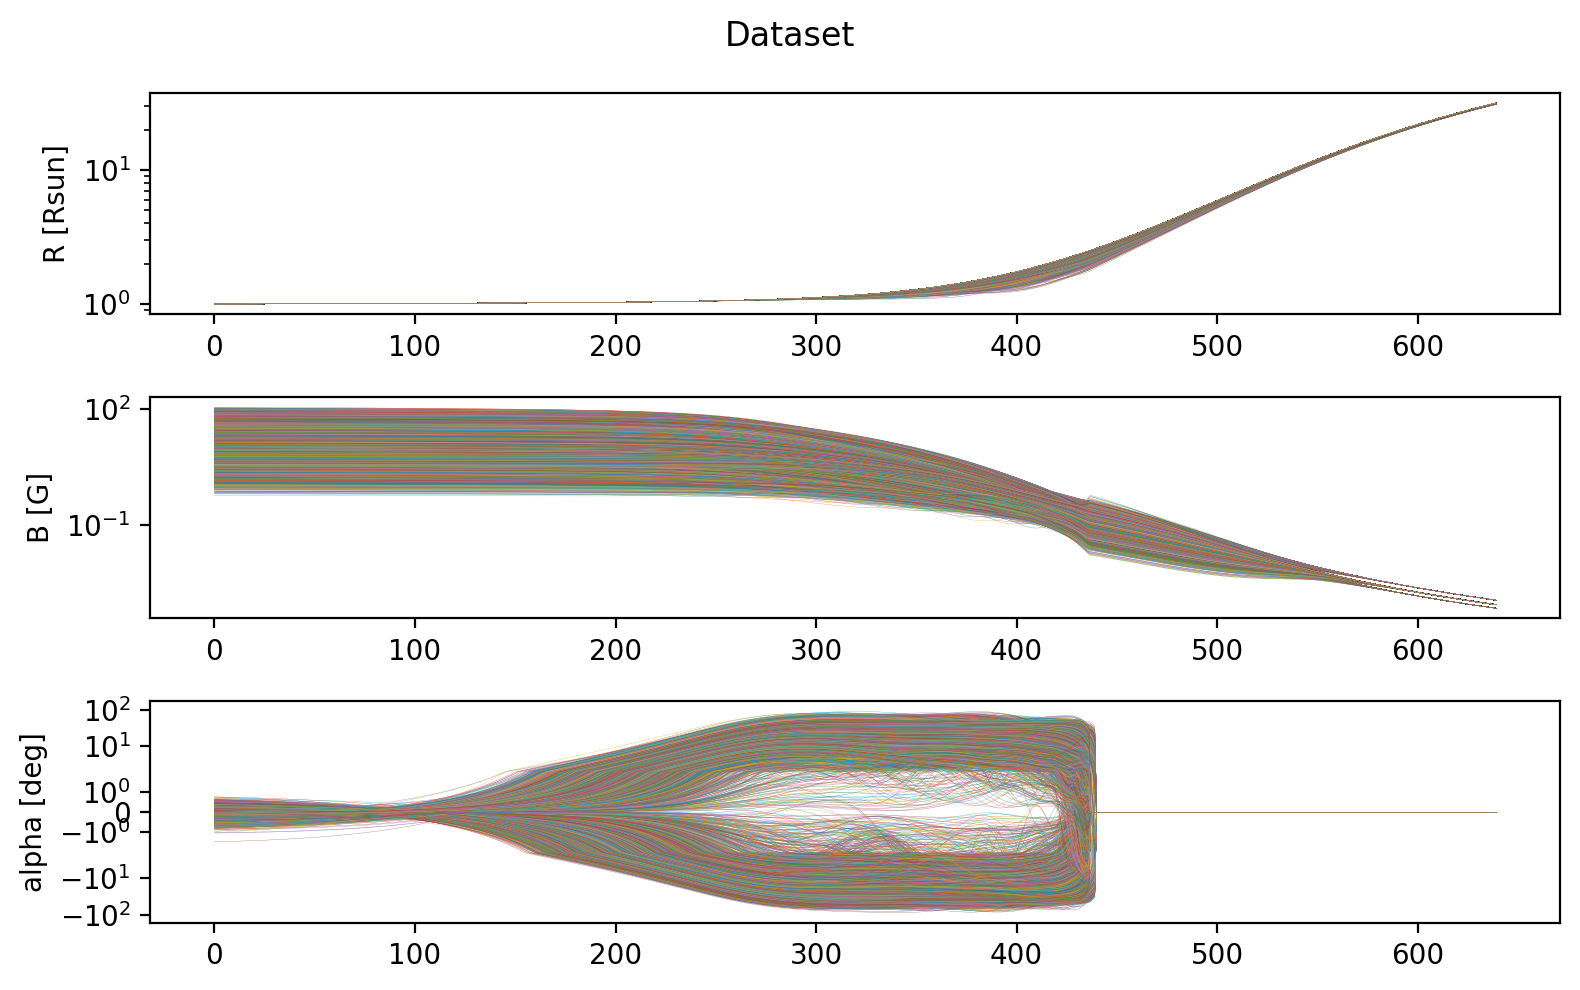

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores, 0.03, opts.data_path, opts_eval.models_dir /  f"img/mse", 
                        scale="log", method="MSE")

### MSE Reconstruction with Discriminator feedback

In [ ]:
reconstr_scores_discr = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                      opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  0.7046477
Found 352 anomalies


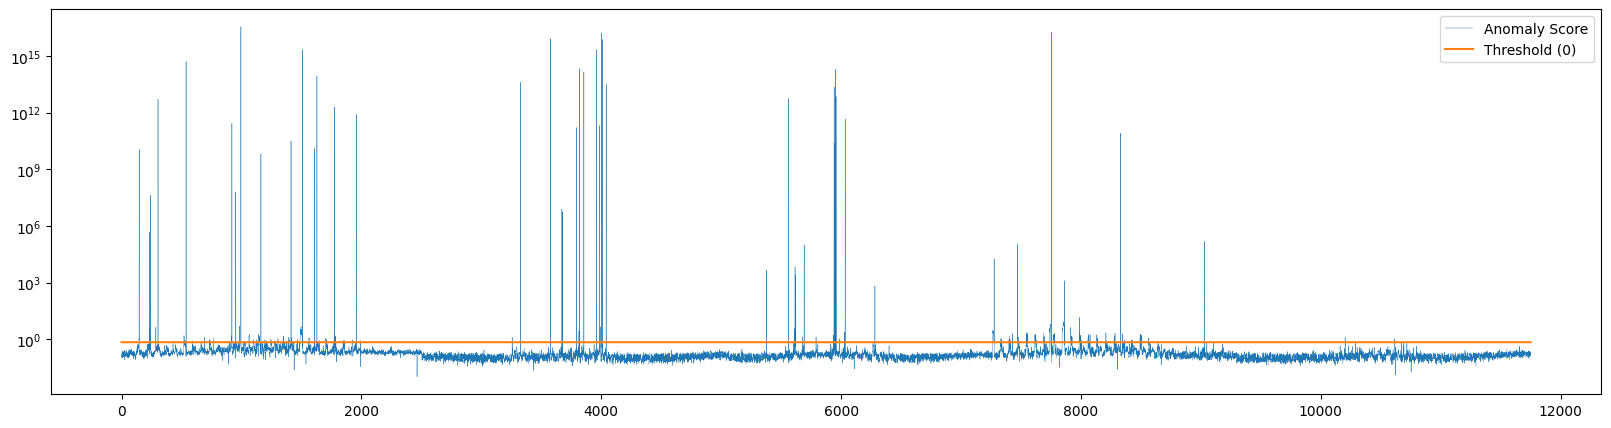

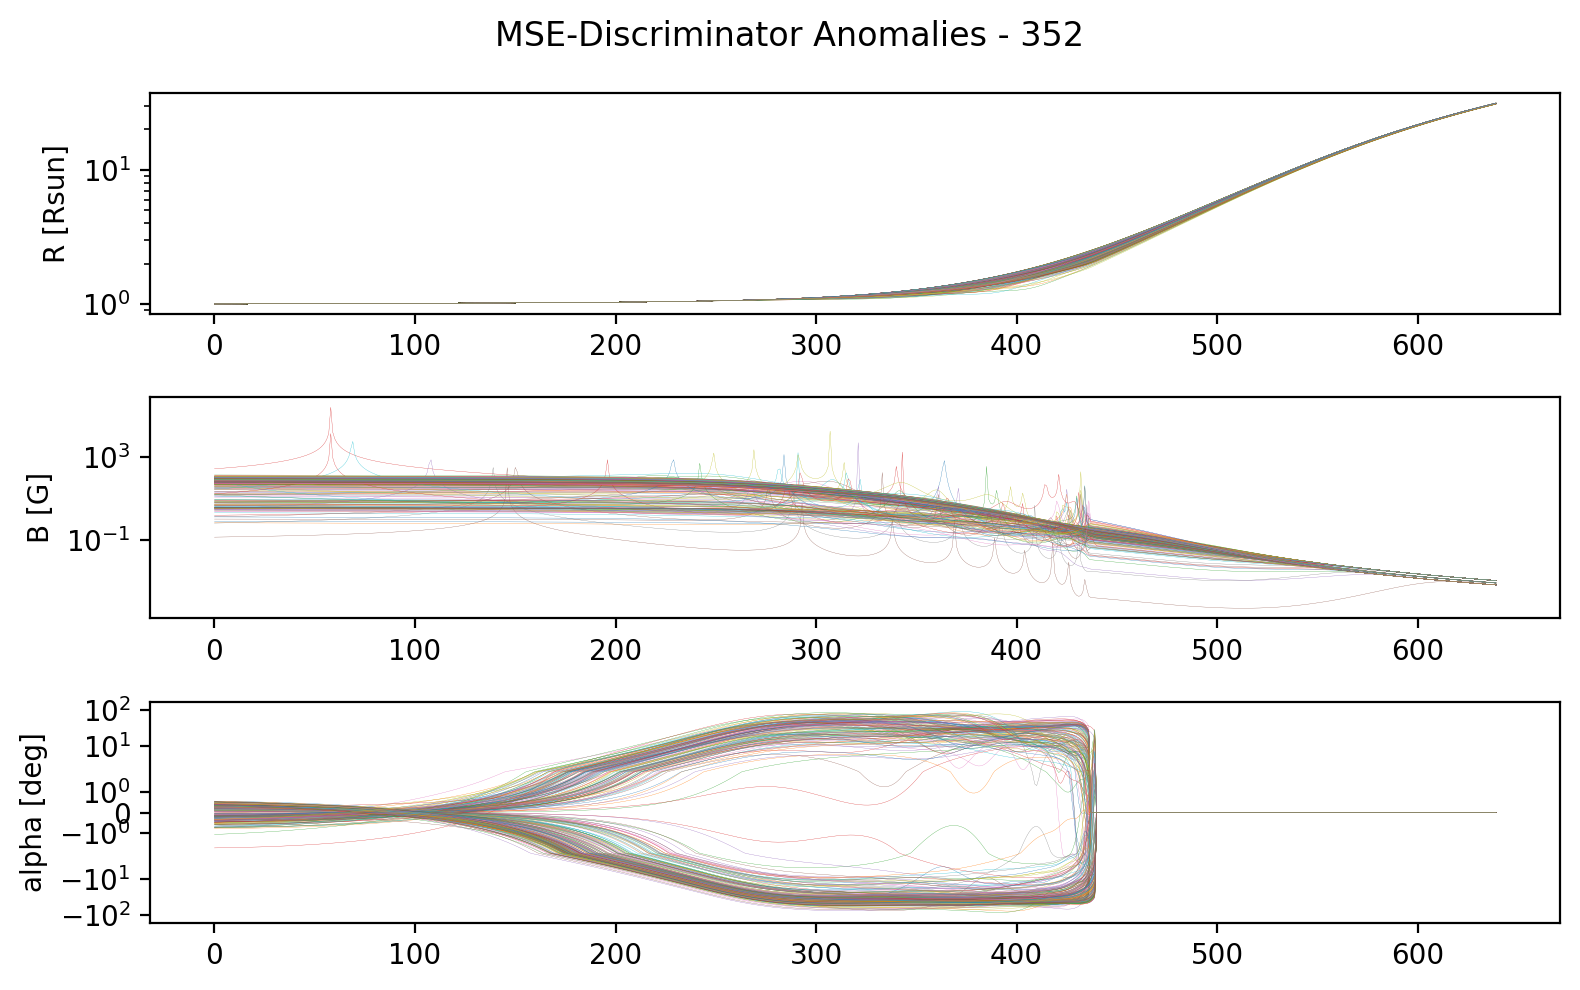

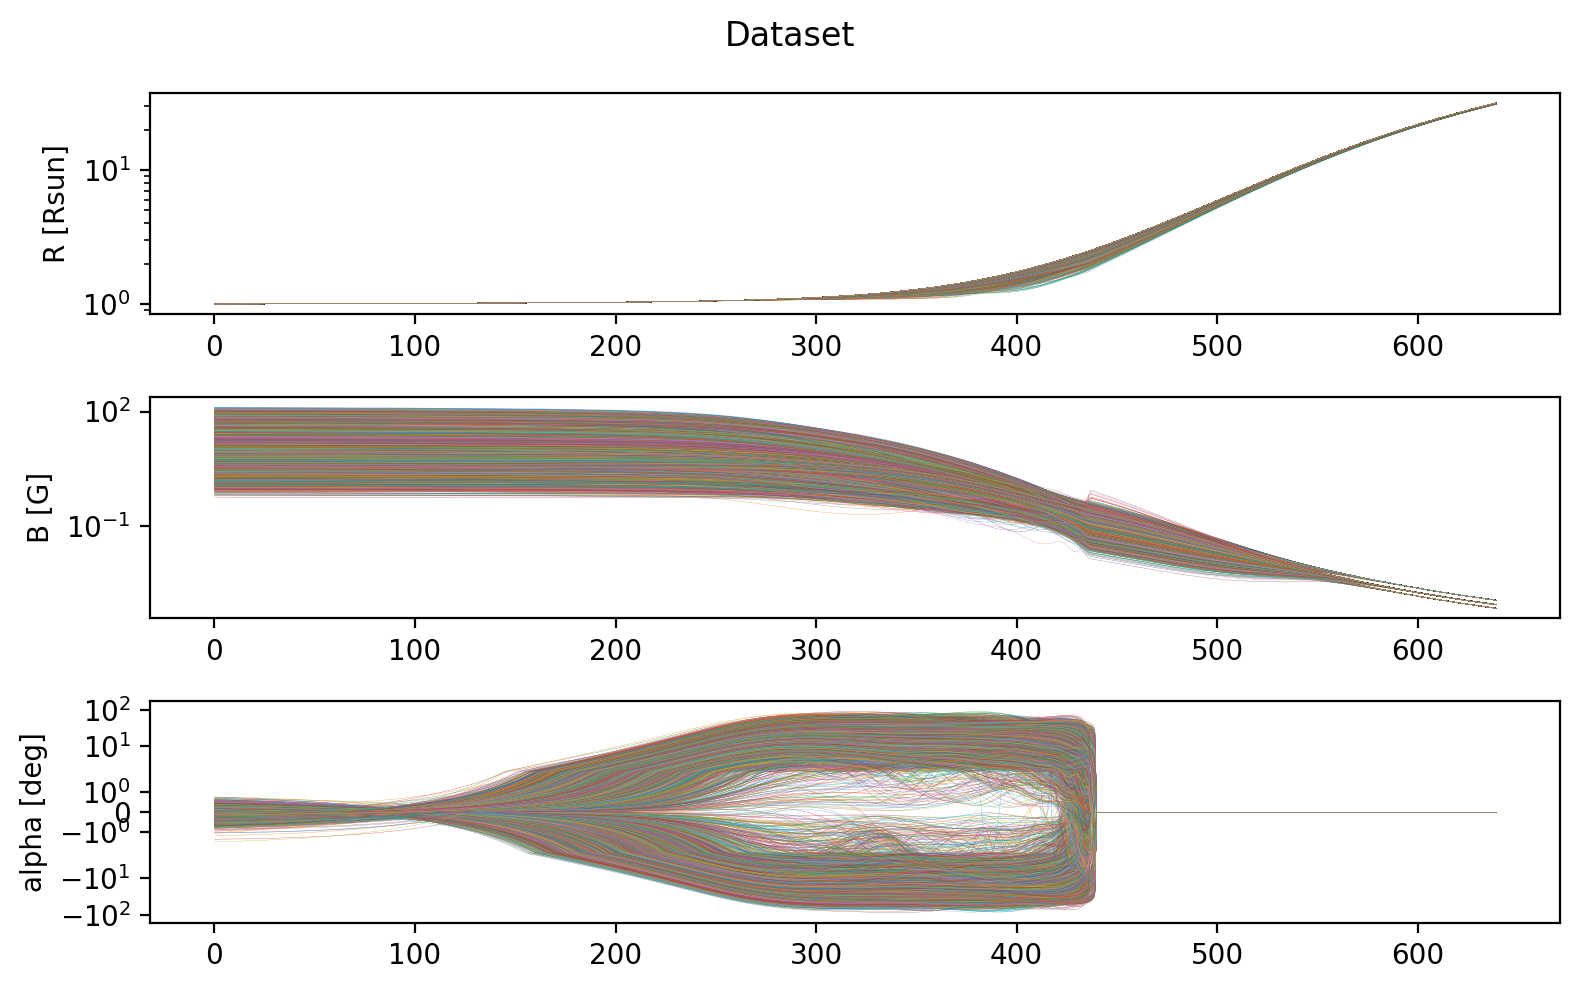

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_scores_discr, 0.03, opts.data_path, opts_eval.models_dir /  f"img/mse_discr",
                        scale="log", method="MSE-Discriminator")

### Feature Reconstruction

In [ ]:
reconstr_feature_scores = reconstruction_anomaly_scores(eval_dataloader, netG, netD, device,
                                                        opts_eval.niter, madgan_reconstruction_discr_loss)

Anomaly Threshold:  0.47716206
Found 587 anomalies


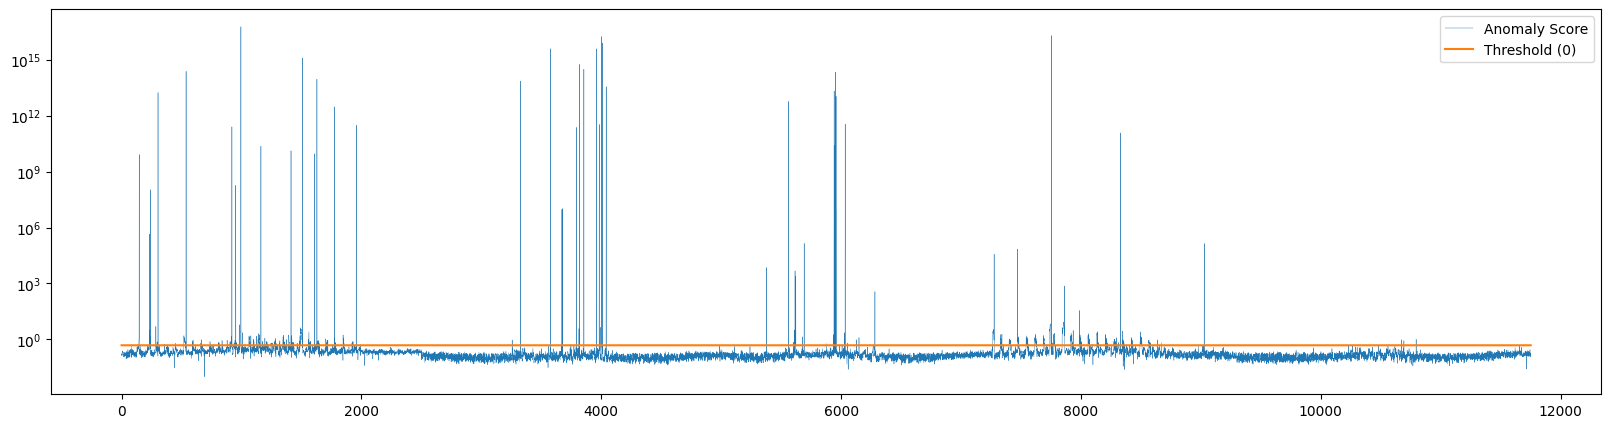

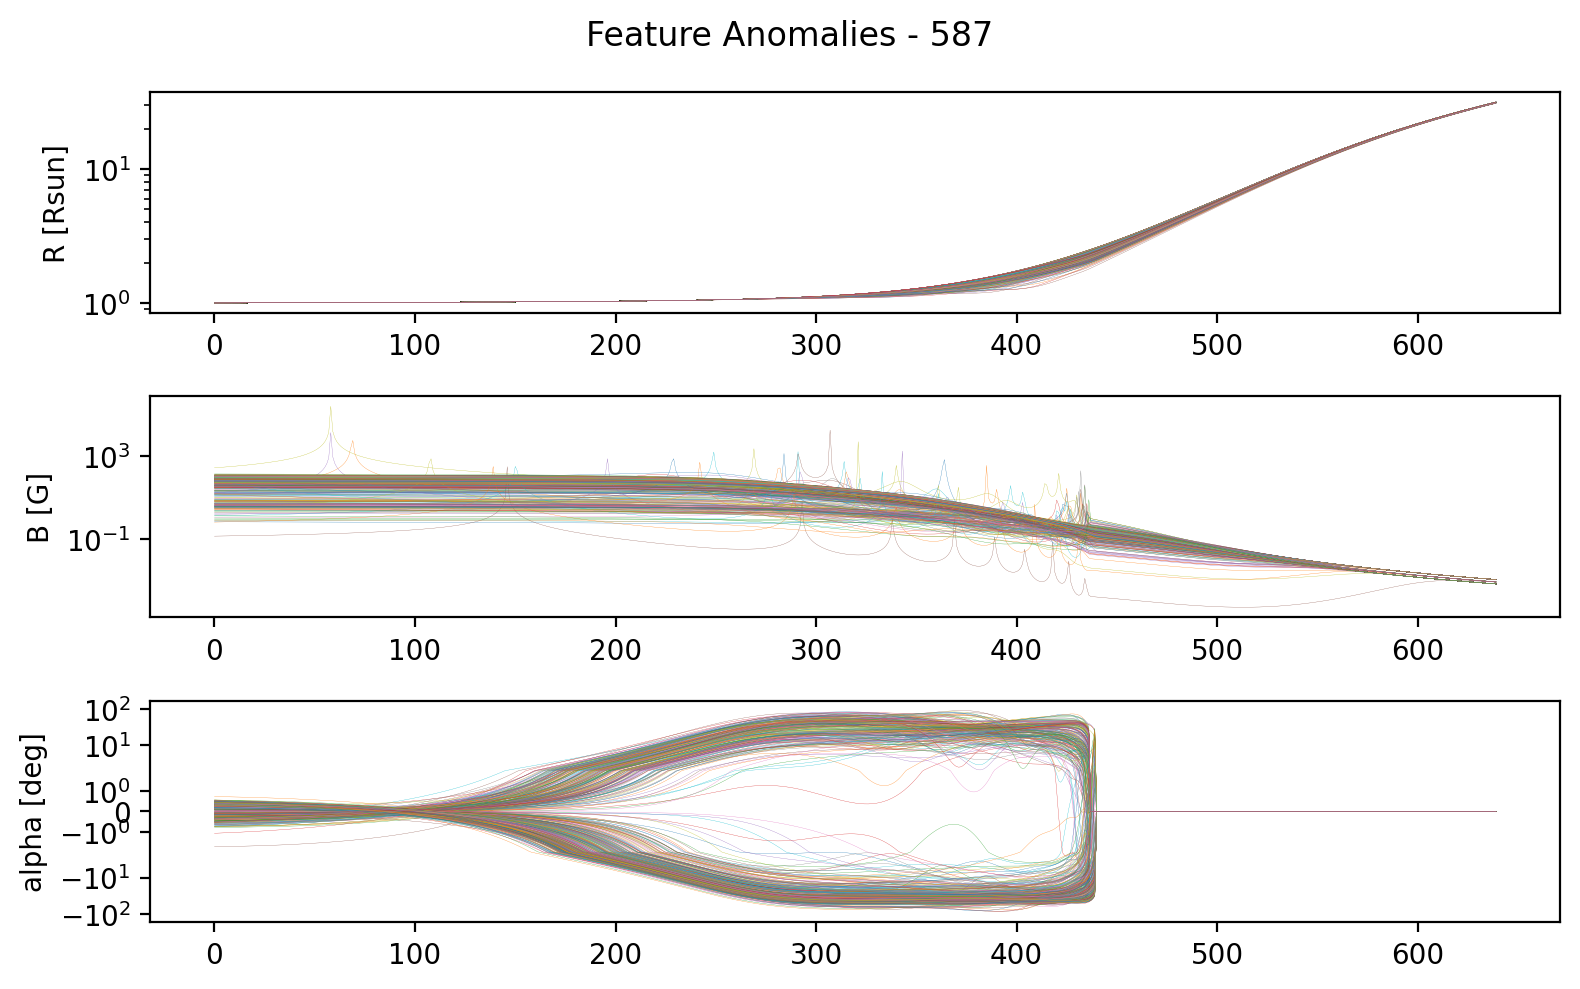

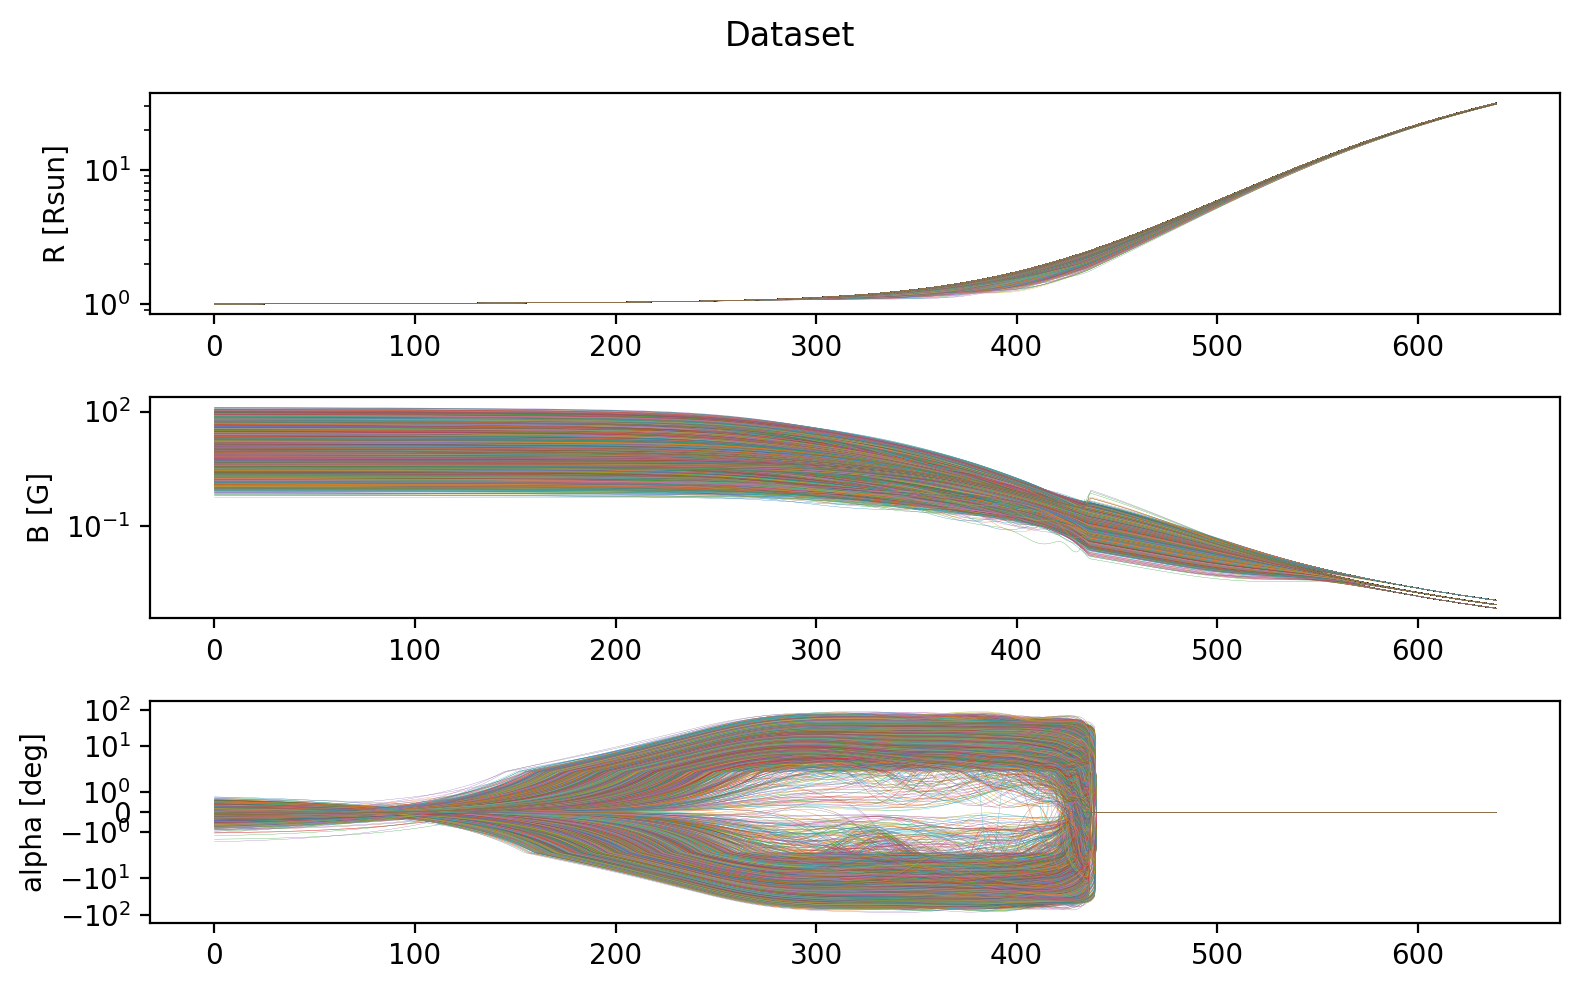

In [ ]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(reconstr_feature_scores, 0.05, opts.data_path, opts_eval.models_dir /  f"img/mse_feature",
                        scale="log", method="Feature")